# **Yelp Review**

---


> **Final project FDS - 2021/2022**
>
> *Team*: Benedetta Candelori, Jacopo Nudo, Luca Palumbo, Alex Onofri, Mina Makar






# Let's have a look at the dataset

Our dataset is divided in different part which we have marged all together. Each part was dealing with: 


1.   Users: it contains informations about reviewer's popularity and about their behaviour on the networ.
2.   Businesses: it contains some general informations about the reviewed company (such as name, address, city) and some others about received reviews (such as the number of reviews, the average score).
3. Reviews: this dataframe contains only the informations that regard the review itself, for example date, assigned stars, text of the review.

In order to obtain a whole dataset we have merged *Users* with *Reviews* due to the *user_id* (an identificator of the user who write the review). Therefore we have merged these two with *Businesses* due to the *business_id* (a code that identifies the reviewed company).



## Preprocess of the dataset

The first thing that a dataset requires to do is the preprocess of the data such that we can remove - or control - missing values, features type and transform some variables that we need in the next analysis. 



#### Let's import some useful libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import json
import sklearn
from sklearn.metrics import accuracy_score
from scipy import sparse
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from datetime import datetime
import warnings
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
!pip install langdetect
from langdetect import detect
import scipy
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set our path 
path_dataset = '/content/drive/MyDrive/FDS_Project/Dataset'

#### Load separated datasets and merge them in a unique dataset

In [ ]:
df_review = pd.read_csv (path_dataset + '/yelp_review.csv')
df_review[~ df_review["stars"].astype(str).str.isdigit()]
df_business = pd.read_csv (path_dataset +'/yelp_business.csv')
df_users = pd.read_csv (path_dataset + '/yelp_user.csv')

##### Drop columns that we are not interested in 

In [ ]:
df_business.drop(columns=["neighborhood", "is_open"], inplace=True)
df_users.drop(columns=["name", "yelping_since", "friends", "elite", 'compliment_hot','compliment_more', 'compliment_profile', 'compliment_cute',
 'compliment_list', 'compliment_note', 'compliment_plain',
'compliment_cool', 'compliment_funny', 'compliment_writer',
'compliment_photos'], inplace=True)
df_business.rename(columns={'stars': 'stars_business',"review_count": "review_business_count"}, inplace = True)
df_review.rename(columns={'stars': 'stars_review', "useful":"useful_review", "funny": "funny_review", "cool": "cool_review"}, inplace = True)
df_users.rename(columns={"useful":"useful_user", "funny": "funny_user", "cool": "cool_user",  "review_count":"review_user_count"}, inplace = True)

##### Merge in *df_merge*

In [ ]:
df_merge = df_review.merge(df_business, on='business_id')
df_merge = df_merge.merge(df_users, on='user_id')

#### Add new features: category and field

* *Category* contains the category of the business (there are 22 categories);
* *Field* indicates the large sectors that includes the respective category; it's a more general classifiction of the business (they are only 5 - *Public services, Restaurants, Health and Wellness, Travels, Shopping*).


In [ ]:
''' Function for assign the right category for each review business '''

def return_main_category(categories):
    # we obtained this list from the website of YELP
    main_categories = {"Active Life", "Arts & Entertainment","Automotive","Beauty & Spas","Education",
                       "Event Planning & Services","Financial Services","Food", "Health & Medical","Home Services",
                       "Hotels & Travel", "Local Flavor","Local Services","Mass Media","Nightlife","Pets",
                       "Professional Services","Public Services & Government","Real Estate","Religious Organizations","Restaurants","Shopping"}
    bool_food = False
    for category in categories:
        if category in main_categories:
            if category == "Food":
                bool_food = True
            else:
                return category
    if bool_food: return "Food"
    return None

In [ ]:
df_merge['category'] = df_merge['categories'].str.split(";").apply(return_main_category)

In [ ]:
# Create the variable field that summaries category

field = []
from tqdm import tqdm
shopping_cat = ['Automotive', 'Shopping'  ,'Real Estate']
haelth_wellness = ['Health & Medical', 'Beauty & Spas', 'Pets']
travel_cat = [ 'Hotels & Travel','Local Flavor']
food_cat = ['Nightlife' ,'Restaurants','Arts & Entertainment', 'Food' , 'Event Planning & Services','Active Life']
social_cat = ['Mass Media','Home Services','Local Services', 'Financial Services','Religious Organizations','Professional Services', 'Education','Public Services & Government']

for i, row in tqdm(df_merge.iterrows()):
  if row.category in social_cat:
    field.append('Public services')
  elif row.category in food_cat:
    field.append('Restaurants')
  elif row.category in haelth_wellness:
    field.append('Health and Wellness')
  elif row.category in travel_cat:
    field.append('Travels')
  elif row.category in shopping_cat:
    field.append('Shopping')

df_merge['field'] = field

#### Drop columns with lots of NA values (such as *Postal Code*) and rows with NA in some features

In [ ]:
df_merge = df_merge.drop(columns=['postal_code'])
df_merge = df_merge[df_merge['category'].notna()]
df_merge = df_merge[df_merge['latitude'].notna()]
df_merge = df_merge[df_merge['state'].notna()]
df_merge = df_merge[df_merge['city'].notna()]

#### Preprocess of the text review
This is one of the main operation of data preprocessing since we are going to process and simplify the text of the reviews.
The steps of this procedure are: 


1.  Delete punctuation.
2.  Tokenization: each text has to be splitted to obtained all separated words (called *tokens*).
3.  Lemming of the words.

Notice that we did not delete stopwords which is one of the main step of preprocess of texts. However we chose to not delete them since they are crucial in Sentiment Analysis in which words such *`no`*, *`not`* or *`neither`* determine wheather the review is positive or negative.



In [ ]:
# function to delete punctuation and get tokenization and lemming
def filter_sentence(description):
  nl = WordNetLemmatizer()
  description = description.translate(str.maketrans('', '', string.punctuation)) # delete punctuation
  word_tokens = word_tokenize(description) # return list of word, very similar to split
  filtered_sentence = [nl.lemmatize(w).lower() for w in word_tokens]
  filtered_description = " ".join(filtered_sentence)
  return filtered_description

In [ ]:
df_merge['text'] = df_merge['text'].apply(filter_sentence)

#### Detect languages
Then we need to detect the language of each review such that we keep only english review in order to avoid problems in Sentiment analysis and in process some models.

We are going to add a new feature: *Language*!

In [ ]:
df_merge["language"] = 'None'
for i, row in df_review.iterrows():
    try:
        df_merge.loc[i, "language"] = detect(row['text'])
    except:
        continue
# Let's keep only the english reviews
df_merge = df_merge[df_merge['language'] == 'en']

#### Our Final Dataset


In [ ]:
df_merge.head(3)

,review_id,user_id,business_id,stars_review,date,useful_review,funny_review,cool_review,name,address,city,state,latitude,longitude,stars_business,review_business_count,categories,review_user_count,useful_user,funny_user,cool_user,fans,average_stars,category,field,language,text
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,0,0,0,"""Wilensky's""","""34 Avenue Fairmount Ouest""",Montréal,QC,45.523333,-73.594859,4.0,84,Diners;Food;Restaurants;Delis,6,0,0,0,0,4.67,Restaurants,Restaurants,en,super simple place but amazing nonetheless its...
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,0,0,0,"""Tuck Shop""","""4662 Rue Notre-Dame O""",Montréal,QC,45.472902,-73.588321,4.5,50,Restaurants;Canadian (New);Italian,6,0,0,0,0,4.67,Restaurants,Restaurants,en,small unassuming place that change their menu ...
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,0,0,0,"""Lester's Deli""","""1057 Avenue Bernard""",Outremont,QC,45.522144,-73.607076,4.0,70,Specialty Food;Food;Sandwiches;Restaurants;Bur...,6,0,0,0,0,4.67,Restaurants,Restaurants,en,lesters is located in a beautiful neighborhood...


# Exploratory Data Analysis 

#### Location of reviewed businesses

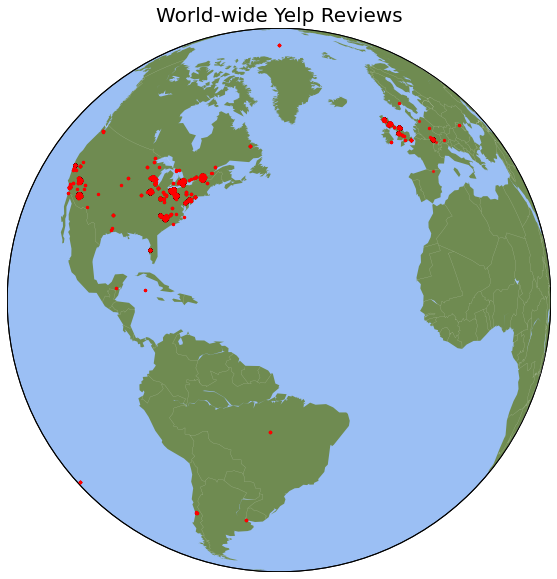

In [ ]:
import imageio
import folium
import folium.plugins as plugins
from mpl_toolkits.basemap import Basemap

#basic basemap of the world
plt.figure(1, figsize=(20,10))
# use ortho projection for the globe type version
m1=Basemap(projection='ortho',lat_0=20,lon_0=-50)

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261
#add continents
m1.fillcontinents(color='#6f8b51',lake_color='#9bbff4', ) 
# add the oceans
m1.drawmapboundary(fill_color='#9bbff4')                
# Draw the boundaries of the countires
m1.drawcountries(linewidth=0.1, color="white")

#Add the scatter points to indicate the locations of the businesses
mxy = m1(df_merge["longitude"].tolist(), df_merge["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="red", lw=1.5, alpha=.7, zorder=5)
plt.title("World-wide Yelp Reviews", fontsize = 20)
plt.show()

#### General plot about correlations between features

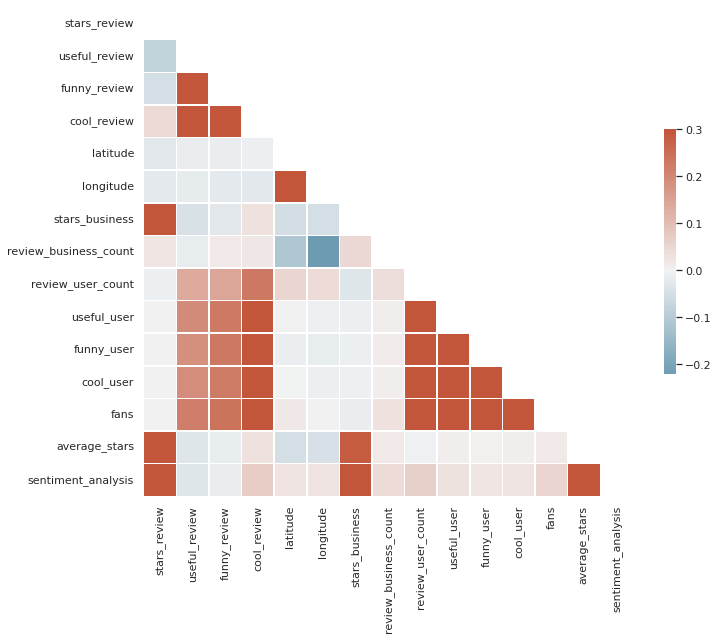

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random datase

# Compute the correlation matrix
corr = df_merge.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As we expected features that regard reviews and those ones that regard users seem to be correlated (positively) one to each others.

#### Take a look at stars review distributions
Reviews with a high number of stars are prevalent



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


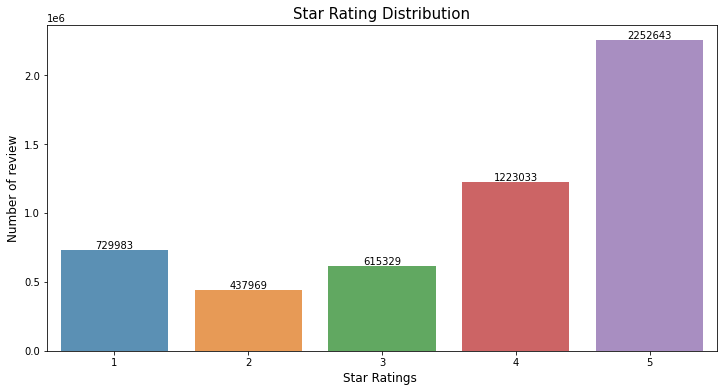

In [ ]:
import seaborn as sns 
x = df_merge['stars_review'].value_counts()
x = x.sort_index()
#plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution", fontsize = 15)
plt.ylabel('Number of review', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

#### Category of the businesses in our dataset

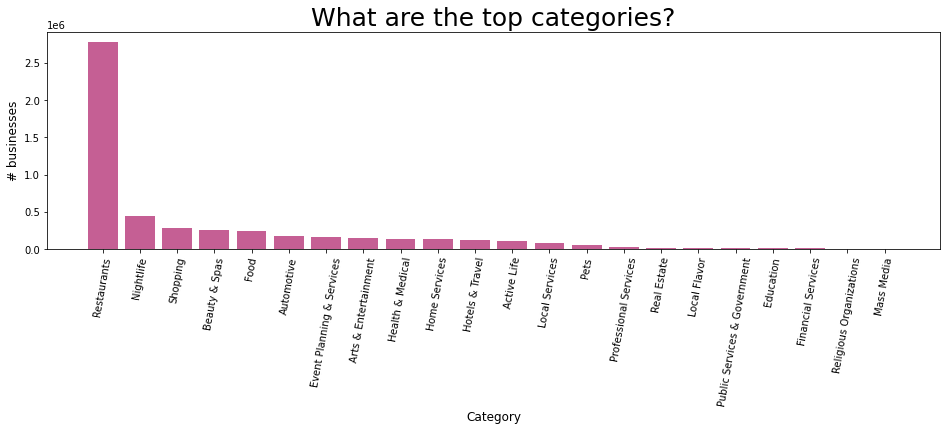

In [ ]:
df_merge["category"] = df_merge["category"].astype(str)
x = df_merge.category.value_counts()

plt.figure(figsize=(16,4))
df_merge.field = pd.Categorical(df_merge.field)
df_merge["fieldN"] = df_merge.field.cat.codes
norm = plt.Normalize(df_merge.fieldN.min(), df_merge.fieldN.max())

cmap = plt.get_cmap("magma")
color = cmap(norm(df_merge.fieldN.values))

plt.bar(x.index, x.values, alpha=0.8,color=cmap(norm(df_merge.fieldN.values)))
plt.title("What are the top categories?",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

labels = x.values

plt.show()

Most of them are restaurants.. that's the reason why we decided to classify businsses into more general categories which are summed up in the variable *field*.




#### Distribution of the stars review for different fields.
Users, in some fields like travel, tend to rate a review much frequently with 2 stars or less.


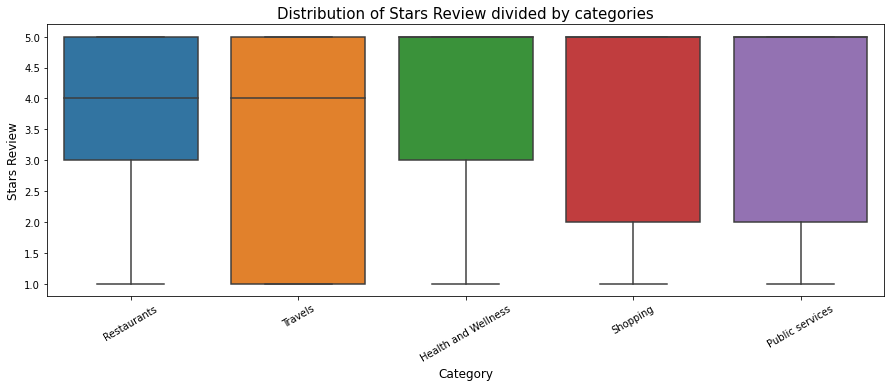

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure 
figure(figsize=(15,5))
ax = sns.boxplot(x=df_merge['field'], y=df_merge["stars_review"])
plt.setp(ax.get_xticklabels(), rotation=30)
plt.xlabel('Category', fontsize = 12)
plt.ylabel('Stars Review',fontsize = 12)
plt.title('Distribution of Stars Review divided by categories', fontsize = 15)
plt.show()

##### Have a look at the most frequent words in Positive, Neutral and Negative Reviews.

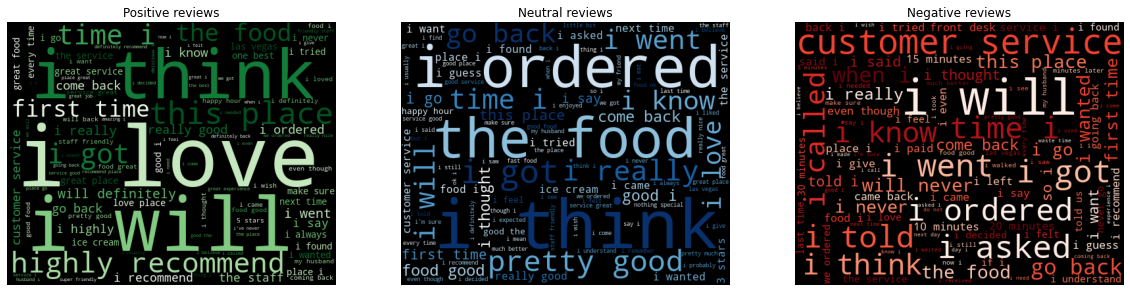

In [ ]:
import string
from wordcloud import WordCloud, STOPWORDS

def remove_punctuation(text, punct=string.punctuation):
  res = ""
  for c in text:
    if c not in punct:
      res += c
  return res

def extract_bigram_frequency(texts, stop_words):
  freqs = {}
  for summary in texts:
    summary = remove_punctuation(summary, set(string.punctuation) - {"'"})
    tokens = [token.lower() for token in summary.split(" ") if token not in string.punctuation and token not in stop_words]
    for i in range(1, len(tokens)):
      w1, w2 = tokens[i-1:i+1]
      key = w1 + " " + w2
      if key in stop_words:
        continue
      if key not in freqs:
        freqs[key] = 0
      freqs[key] += 1
  return freqs

stop_words = STOPWORDS.union({"one star", "two stars", "three stars", "four stars", "five stars"})
corpus = [
    ("Positive reviews", df_merge[(df_merge["stars"] >= 4.0)]["text"], "Greens"),
    ("Neutral reviews", df_merge[df_merge["stars"] == 3.0]["text"], "Blues"),
    ("Negative reviews", df_merge[(df_merge["stars"] <= 2.0)]["text"], "Reds")
]

fig, axs = plt.subplots(1, 3, figsize=(20, 14))
for i in range(len(axs)):
  title, texts, cmap = corpus[i]
  freqs = extract_bigram_frequency(texts, stop_words)
  wc = WordCloud(height=400, width=500, colormap=cmap, max_words=100).generate_from_frequencies(freqs)
  axs[i].imshow(wc)
  axs[i].axis("off")
  axs[i].title.set_text(title)

# Vader Sentiment Analysis on text review

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# compute sentiment scores for each review
df_merge["sentiment_analysis"] = df_merge["text"].apply(lambda review: (sid.polarity_scores(review)['compound']) if review != 0 else review)


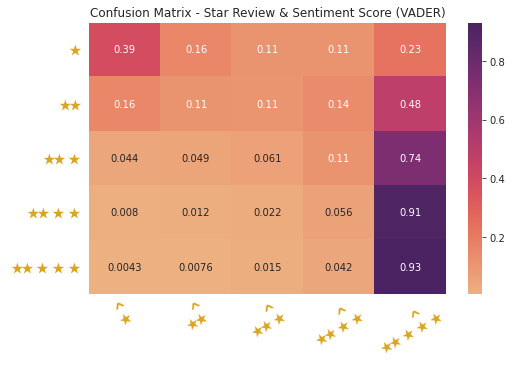

In [ ]:
from sklearn.metrics import confusion_matrix

# Categorize sentiment analysis scores into 5 classes to have a correspondence with the 5 stars classification 

df_merge['sentiment_classes'] = pd.cut(df_merge.sentiment_analysis,5, labels=["1", "2",'3','4','5'])
df_merge['sentiment_classes'] = df_merge['sentiment_classes'].astype(int)

# confusion matrix between stars review and sentiement score (discretized)

confmat = confusion_matrix(y_true=df_merge['stars_review'], y_pred=df_merge['sentiment_classes'])
confmat = confmat / confmat.astype(np.float).sum(axis=1)
index = ["Star: 1", "Star: 2", "Star 3", "Star 4", "Star 5"]
columns = ["Predicted Star 1", "Predicted Star 2", "Predicted Star 3", "Predicted Star 4", "Predicted Star 5"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
res = sns.heatmap(conf_matrix, annot=True, cmap="flare", 
            yticklabels=[r'$\star$','$\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star$'],
            xticklabels=[r'$\hat{\star}$','$\hat{\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star}$'])
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 30 , color = 'goldenrod', rotation = 30)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 30, color = 'goldenrod', rotation = 0)
plt.title("Confusion Matrix - Star Review & Sentiment Score (VADER)")
plt.show()


# Models to predict stars review based on the text of the reviews: Sentiment Analysis



## Models for balanced dataset

Make the dataset balanced with under sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

features = set(df_merge.columns) - {"stars_review"}
X, y = df_merge[features], df_merge["stars_review"]
# Undersample the minority classes to balance them
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)
X_under, y_under = pd.DataFrame(X_under, columns=X.columns), pd.Series(y_under, name=y.name)

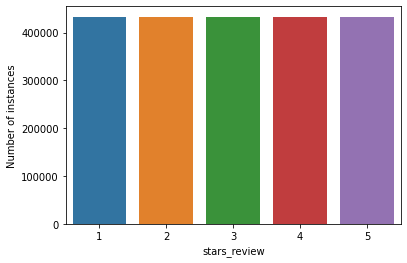

In [ ]:
sns.countplot(x=y_under)
plt.xlabel("stars_review")
plt.ylabel("Number of instances")
plt.show()

In [ ]:
# TFIDF process
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii')
X_under = vectorizer.fit_transform(X_under['text'])
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42, train_size=0.7)

### Naive Bayes Bernulli

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
# y proba multinomial NB
y_score_multiNB = nb_classifier.predict_proba(X_test)

In [ ]:
nb_classifier.score(X_test, y_test) #accuracy

0.5801291916098552

### Naive Bayes Multinomial

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
# y proba bernulli NB
y_score_bernNB = clf.predict_proba(X_test)

In [ ]:
clf.score(X_test, y_test) #accuracy

0.6870489066034687

### Softmax Regression

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train.values.reshape(-1,1), y_train)

In [ ]:
lm.score(X_test.values.reshape(-1,1), y_test)

0.5097534920463931

In [ ]:
y_pred = lm.predict(X_test.values.reshape(-1,1))
# y proba bernulli NB
y_score_logistic = lm.predict_proba(X_test)

## Models for unbalanced dataset

In [ ]:
# keep 2 million records to obtain a dataset with the same shape of the balanced dataset
df_sample = df_merge.sample(2000000) # dataset unbalanced with the same number of row of the balanced one

# TFIDF process
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii')
X = vectorizer.fit_transform(df_sample['text'])
y = df_sample["stars_review"]
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, random_state=42, train_size=0.7)

### Naive Bayes Bernulli

In [ ]:
clf = BernoulliNB()
clf.fit(X_train_unb, y_train_unb)
# y proba bernulli NB
y_score_bernNB_unb = clf.predict_proba(X_test_unb)

In [ ]:
clf.score(X_test_unb, y_test_unb)

0.5367266666666667

### Naive Bayes Multinomial

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_unb, y_train_unb)
# y proba multinomial NB
y_score_multiNB_unb = nb_classifier.predict_proba(X_test_unb)


In [ ]:
nb_classifier.score(X_test_unb, y_test_unb)

0.5401816666666667

### Softmax Regression

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train_unb, y_train_unb)
y_logistic_pred = lm.predict(X_test_unb)
y_score_logistic_unb = lm.predict_proba(X_test_unb)

In [ ]:
lm.score(X_test_unb, y_test_unb)

0.6679033333333333

## ROC and PR curves


In [ ]:
Y = label_binarize(y_test, classes = [1, 2, 3, 4, 5])
Y_unb = label_binarize(y_test_unb, classes = [1, 2, 3, 4, 5])

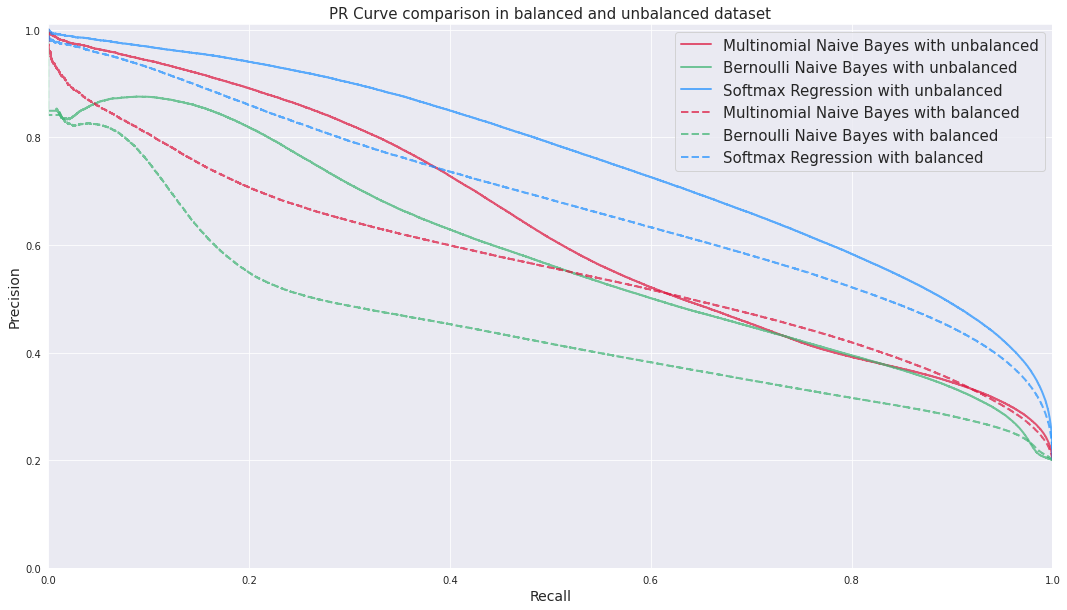

In [ ]:
# for balanced
# PR e ROC multinomial NB
precision_MultiNB, recall_MultiNB, _ = precision_recall_curve(Y.ravel(), y_score_multiNB.ravel())
fpr_MultiNB, tpr_MultiNB, _ = roc_curve(Y.ravel(), y_score_multiNB.ravel())

# PR e ROC bernulli NB
precision_BernNB, recall_BernNB, _ = precision_recall_curve(Y.ravel(), y_score_bernNB.ravel())
fpr_BernNB, tpr_BernNB, _ = roc_curve(Y.ravel(), y_score_bernNB.ravel())

# PR e ROC softmax regression 
precision_logistic, recall_logistic, _ = precision_recall_curve(Y.ravel(), y_score_logistic.ravel())
fpr_logistic, tpr_logistic, _ = roc_curve(Y.ravel(), y_score_logistic.ravel())


# for unbalanced
# PR e ROC multinomial NB
precision_MultiNB_unb, recall_MultiNB_unb, _ = precision_recall_curve(Y_unb.ravel(), y_score_multiNB_unb.ravel())
fpr_MultiNB_unb, tpr_MultiNB_unb, _ = roc_curve(Y_unb.ravel(), y_score_multiNB_unb.ravel())

# PR e ROC bernulli NB
precision_BernNB_unb, recall_BernNB_unb, _ = precision_recall_curve(Y_unb.ravel(), y_score_bernNB_unb.ravel())
fpr_BernNB_unb, tpr_BernNB_unb, _ = roc_curve(Y_unb.ravel(), y_score_bernNB_unb.ravel())

# PR e ROC softmax regression 
precision_logistic_unb, recall_logistic_unb, _ = precision_recall_curve(Y_unb.ravel(), y_score_logistic_unb.ravel())
fpr_logistic_unb, tpr_logistic_unb, _ = roc_curve(Y_unb.ravel(), y_score_logistic_unb.ravel())


# PR curve with unbalnaced dataset

plt.figure(figsize=(18, 10))
sns.set_style("darkgrid")
#multiNB
plt.step(recall_MultiNB_unb, precision_MultiNB_unb, where="post", label = 'Multinomial Naive Bayes with unbalanced',  color = 'crimson', linewidth=2, alpha =.7 )
#BernNB
plt.step(recall_BernNB_unb, precision_BernNB_unb, where="post", label = 'Bernoulli Naive Bayes with unbalanced',color = 'mediumseagreen', linewidth=2, alpha =.7)
# softmax
plt.step(recall_logistic_unb, precision_logistic_unb, where="post", label = 'Softmax Regression with unbalanced',color = 'dodgerblue', linewidth=2, alpha =.7)



# PRM with balanced data
#multiNB
plt.step(recall_MultiNB, precision_MultiNB, where="post", label = 'Multinomial Naive Bayes with balanced',  color = 'crimson', linewidth=2,linestyle = '--' , alpha =.7)
#BernNB
plt.step(recall_BernNB, precision_BernNB, where="post", label = 'Bernoulli Naive Bayes with balanced',color = 'mediumseagreen', linewidth=2,linestyle = '--', alpha =.7)
# softmax
plt.step(recall_logistic, precision_logistic, where="post", label = 'Softmax Regression with balanced',color = 'dodgerblue', linewidth=2,linestyle = '--', alpha =.7)



plt.xlabel("Recall", fontsize = 14)
plt.ylabel("Precision", fontsize = 14)
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve comparison in balanced and unbalanced dataset",fontsize = 15)
plt.legend(fontsize = 15, markerscale = .7)
plt.show()

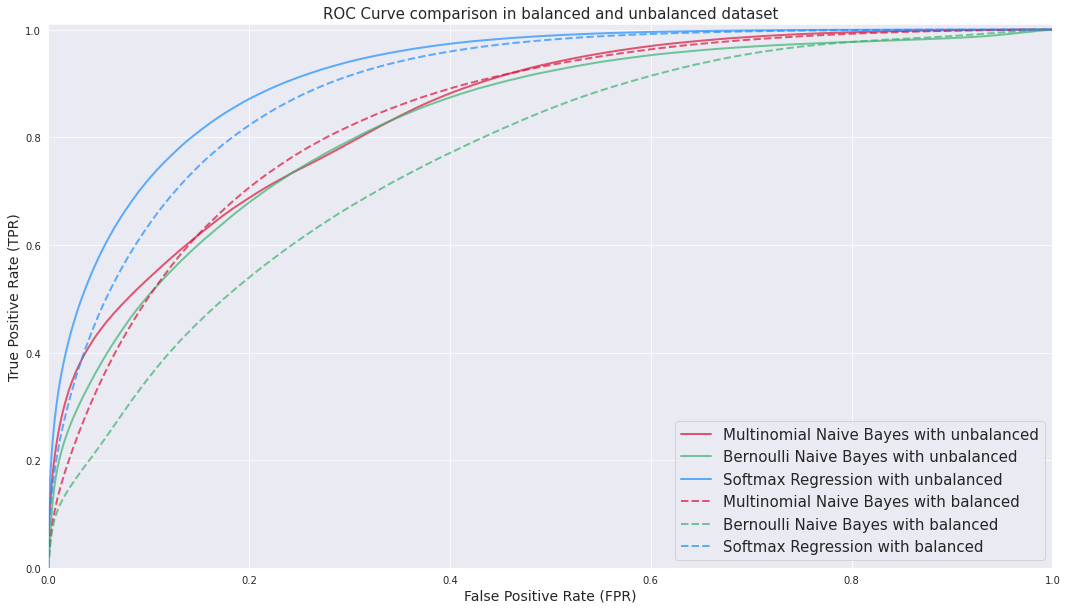

In [ ]:
# ROC curves

plt.figure(figsize=(18, 10))
sns.set_style("darkgrid")
# ROC with unbalanced 
#multiN2
plt.step(fpr_MultiNB_unb, tpr_MultiNB_unb, where="post", label = 'Multinomial Naive Bayes with unbalanced', color = 'crimson', linewidth=2, alpha =.7)
#BernNB
plt.step(fpr_BernNB_unb, tpr_BernNB_unb, where="post", label = 'Bernoulli Naive Bayes with unbalanced', color = 'mediumseagreen', linewidth=2,  alpha =.7)
# softmax
plt.step(fpr_logistic_unb, tpr_logistic_unb, where="post", label = 'Softmax Regression with unbalanced', color = 'dodgerblue', linewidth=2, alpha =.7)



# ROC with balanced
#multiN2
plt.step(fpr_MultiNB, tpr_MultiNB, where="post", label = 'Multinomial Naive Bayes with balanced', color = 'crimson', linewidth=2 , linestyle = '--', alpha =.7)
#BernNB
plt.step(fpr_BernNB, tpr_BernNB, where="post", label = 'Bernoulli Naive Bayes with balanced', color = 'mediumseagreen', linewidth=2, linestyle = '--', alpha =.7)
# softmax
plt.step(fpr_logistic, tpr_logistic, where="post", label = 'Softmax Regression with balanced', color = 'dodgerblue', linewidth=2, linestyle = '--', alpha =.7)



plt.xlabel("False Positive Rate (FPR)", fontsize = 14)
plt.ylabel("True Positive Rate (TPR)", fontsize = 14)
plt.xlim([0, 1])
plt.ylim([0, 1.01])

plt.title("ROC Curve comparison in balanced and unbalanced dataset", fontsize = 15)
plt.legend(fontsize = 15, markerscale = .7)
plt.show()



## Confusion Matrix

**For balanced dataset**

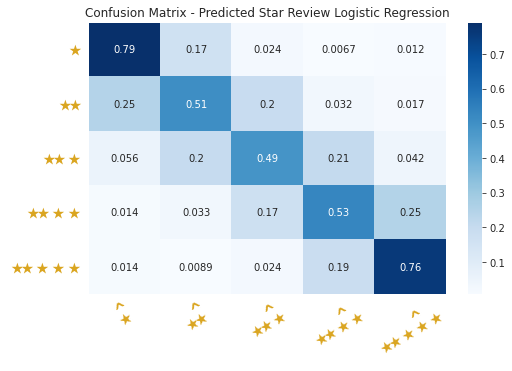

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_logistic)
confmat = confmat / confmat.astype(np.float).sum(axis=1)
index = ["Star: 1", "Star: 2", "Star 3", "Star 4", "Star 5"]
columns = ["Predicted Star 1", "Predicted Star 2", "Predicted Star 3", "Predicted Star 4", "Predicted Star 5"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize = (8, 5))
res = sns.heatmap(conf_matrix, annot = True, cmap = "Blues", 
            yticklabels=[r'$\star$','$\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star$'],
            xticklabels=[r'$\hat{\star}$','$\hat{\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star}$'])
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 30 , color = 'goldenrod', rotation = 30)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 30, color = 'goldenrod', rotation = 0)
plt.title("Confusion Matrix - Predicted Star Review softmax Regression")
plt.show()

**For unbalanced dataset**

In [ ]:
confmat = confusion_matrix(y_true=y_test_unb, y_pred=y_logistic_pred_unb)
confmat = pd.DataFrame(confmat) 
confmat = confmat.div(confmat.sum(axis=1), axis=0)

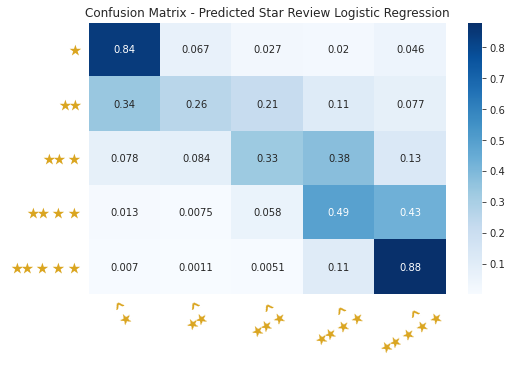

In [ ]:
index = ["Star: 1", "Star: 2", "Star 3", "Star 4", "Star 5"]
columns = ["Predicted Star 1", "Predicted Star 2", "Predicted Star 3", "Predicted Star 4", "Predicted Star 5"]
conf_matrix = pd.DataFrame(data = confmat, columns = columns, index = index)
plt.figure(figsize = (8, 5))
res = sns.heatmap(confmat, annot=True, cmap="Blues", 
            yticklabels = [r'$\star$','$\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star$','$\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star$'],
            xticklabels = [r'$\hat{\star}$','$\hat{\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star}$','$\hat{\star\!\!\!\star\!\!\!\star\!\!\!\star\!\!\!\star}$'])
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 30 , color = 'goldenrod', rotation = 30)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 30, color = 'goldenrod', rotation = 0)
plt.title("Confusion Matrix - Predicted Star Review softmax Regression")
plt.show()

## Models applied for split datasets based on field

In [ ]:
def checkAccuracyPerCategory(df_merge, category):
    df = df_merge[df_merge['field'] == category]
    features = set(df.columns) - {"stars_review"}
    X, y = df[features], df["stars_review"]
    X_under = X
    y_under = y
    vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii')
    X_under = vectorizer.fit_transform(X_under['text'])
    X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42, train_size=0.7)

    # Multinomial
    nb_classifier = MultinomialNB()
    nb_classifier.fit(X_train, y_train)
    print("Accuracy Multinomial train", nb_classifier.score(X_train, y_train)) #accuracy
    print("Accuracy Multinomial test", nb_classifier.score(X_test, y_test)) #accuracy

    # Bernoulli
    clf = BernoulliNB()
    clf.fit(X_train, y_train)
    print("Accuracy BernoulliNB train:", clf.score(X_train, y_train))
    print("Accuracy BernoulliNB test:", clf.score(X_test, y_test))

    lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
    lm.fit(X_train, y_train)
    print("Accuracy softmax Regression train", lm.score(X_train, y_train)) #accuracy
    print("Accuracy softmax Regression test", lm.score(X_test, y_test)) #accuracy
    
    return nb_classifier.predict, clf.predict, lm.predict, y_test

#### Travels

In [ ]:
travel_nbmulti, travel_nbbern, travel_log, travel_test = checkAccuracyPerCategory(df_merge, "Travels")

Accuracy Multinomial train 0.6060863614287606
Accuracy Multinomial test 0.5713807402065573
Accuracy BernoulliNB train: 0.58372334319396
Accuracy BernoulliNB test: 0.5237849949777217
Accuracy Logistic Regression train 0.7242041591240231
Accuracy Logistic Regression test 0.6439848558992454


#### Health and Wellness

In [ ]:
health_nbmulti, health_nbbern, health_log, health_test = checkAccuracyPerCategory(df_merge, 'Health and Wellness')

Accuracy Multinomial train 0.7461680450526962
Accuracy Multinomial test 0.7420423384885378
Accuracy BernoulliNB train: 0.7317991933386192
Accuracy BernoulliNB test: 0.715337647618003
Accuracy Logistic Regression train 0.8380597506056228
Accuracy Logistic Regression test 0.8197652736645826


#### Shopping

In [ ]:
shop_nbmulti, shop_nbbern, shop_log, shop_test=checkAccuracyPerCategory(df_merge, 'Shopping')

Accuracy Multinomial train 0.6696525895929117
Accuracy Multinomial test 0.6632399329335872
Accuracy BernoulliNB train: 0.6477361994945651
Accuracy BernoulliNB test: 0.6243783568728865
Accuracy Logistic Regression train 0.7785098803397984
Accuracy Logistic Regression test 0.7458864986217284


#### Public services

In [ ]:
public_nbmulti, public_nbbern, public_log, public_test=checkAccuracyPerCategory(df_merge, 'Public services')

Accuracy Multinomial train 0.7778362148102815
Accuracy Multinomial test 0.7726943115008311
Accuracy BernoulliNB train: 0.7498087515299877
Accuracy BernoulliNB test: 0.7378984124859154
Accuracy Logistic Regression train 0.860890644124847
Accuracy Logistic Regression test 0.8432455347680088


#### Restaurants

In [ ]:
rest_nbmulti, rest_nbbern, rest_log, rest_test=checkAccuracyPerCategory(df_merge, 'Restaurants')

Accuracy Multinomial train 0.5282901524374726
Accuracy Multinomial test 0.5081044063212462
Accuracy BernoulliNB train: 0.5319302839399167
Accuracy BernoulliNB test: 0.5090154910408557
Accuracy Logistic Regression train 0.661226283696201
Accuracy Logistic Regression test 0.6336113109737597


#### In order to compute the overall accuracy for the model in the datasets split by fields we merged the predictions for each model.

In [ ]:
all_test = np.concatenate((health_test, public_test, rest_test, shop_test, travel_test))

In [ ]:
all_log = np.concatenate((health_log, public_log,rest_log, shop_log, travel_log))

In [ ]:
all_nbmulti = np.concatenate((health_nbmulti, public_nbmulti,rest_nbmulti, shop_nbmulti, travel_nbmulti))

In [ ]:
all_nbbern = np.concatenate((health_nbbern, public_nbbern,rest_nbbern, shop_nbbern, travel_nbbern))

In [ ]:
# logisti 
print('Accuracy logistic ',sklearn.metrics.accuracy_score(all_test, all_log))
# nb multi
print('Accuracy NB Multinomial ' ,sklearn.metrics.accuracy_score(all_test, all_nbmulti))
# nb bern
print('Accuracy NB Bernulli ' ,sklearn.metrics.accuracy_score(all_test, all_nbbern))

Accuracy logistic  0.672375596728533
Accuracy NB Multinomial  0.559402902769718
Accuracy NB Bernulli  0.5510427720905777


## Compare all models

##### For overall accuracy

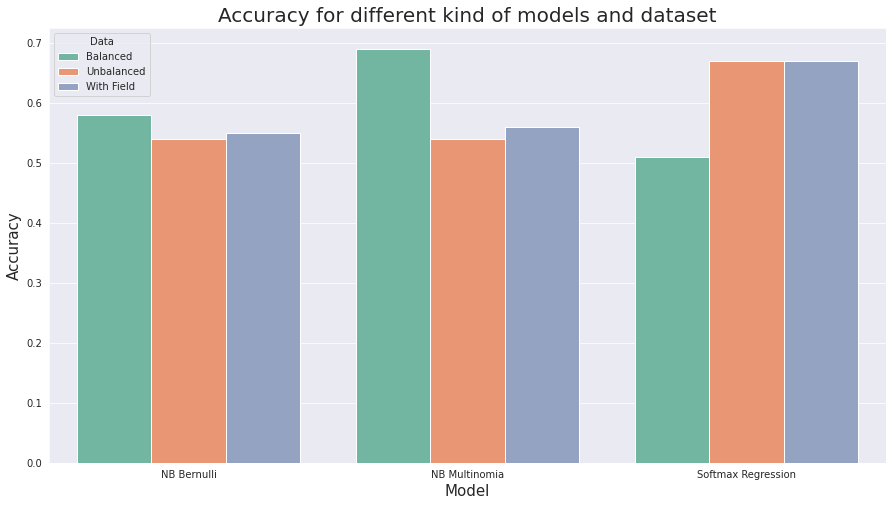

In [ ]:
data = {'Accuracy': [0.58, 0.69, 0.51, 0.54, 0.54, 0.67, 0.55, 0.56 , 0.67],
        'Model': ['NB Bernulli', 'NB Multinomia', 'Softmax Regression', 'NB Bernulli', 'NB Multinomia', 'Softmax Regression','NB Bernulli', 'NB Multinomia', 'Softmax Regression'],
        'Data' : ['Balanced','Balanced','Balanced','Unbalanced','Unbalanced','Unbalanced','With Field','With Field','With Field']}  
  
# Create DataFrame  
df = pd.DataFrame(data)  
 
plt.figure(figsize = (15,8))
ax = sns.barplot(x="Model", y="Accuracy", hue="Data", data=df, palette="Set2")
plt.xlabel('Model', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Accuracy for different kind of models and dataset', fontsize = 20)
plt.show()


# Focus on restaurants in  Toronto


In [ ]:
# keep only restaurants in Toronto
Toronto = df_merge[df_merge["city"] == "Toronto"]
Toronto = Toronto[Toronto["field"] == "Restaurants"]

In [ ]:
Toronto.shape

(364494, 28)

In [ ]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster
 
# make a data frame with dots to show on the map
data = df_merge[['longitude','latitude','name',"field",'stars_business','address']].head(1000)
 
# create an empty map
toronto_map = folium.Map(location=[43.6532,- 79.3832], tiles='Stamen Terrain', zoom_start=12)
 
# add marker one by one on the map
for i in range(0,len(data)):
    test = folium.Html('<b>Name: </b>'+ data.iloc[i]['name'] + "<hr style='margin:10px;'>" + 
                       "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>" +
                       "<li>Field: "+str(data.iloc[i]['field'])+"</li>"+
                       "<li>Stars: "+str(data.iloc[i]['stars_business'])+"</li>"+
                       "<li>Address: "+str(data.iloc[i]['address'])+"</li>", script=True) #"<li><i class=far fa-star></i>stars_business</li>"

    popup = folium.Popup(test, max_width=2650)
    folium.Marker([ data.iloc[i]['latitude'], data.iloc[i]['longitude'] ], popup=popup).add_to(toronto_map)

In [ ]:
toronto_map 

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii')
toronto_text = vectorizer.fit_transform(Toronto['text'])
toronto_star = Toronto['stars_review']

toronto_x_train, toronto_x_test, toronto_y_train, toronto_y_test = train_test_split(toronto_text, toronto_star, random_state=42, train_size=0.7)

In [ ]:
effective_word = vectorizer.get_feature_names()

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(toronto_x_train, toronto_y_train)

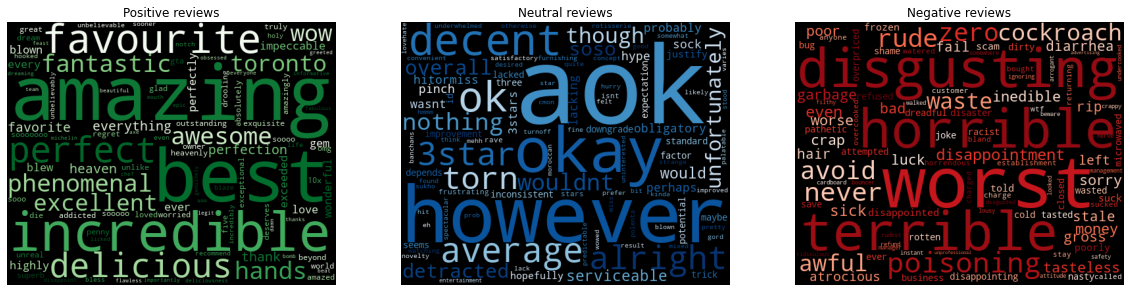

In [ ]:
import string
from wordcloud import WordCloud, STOPWORDS
stop_words = STOPWORDS.union({"one star", "two stars", "three stars", "four stars", "five stars"})
corpus = [
    ("Positive reviews", "Greens"),
    ("Neutral reviews",  "Blues"),
    ("Negative reviews", "Reds")
]

fig, axs = plt.subplots(1, 3, figsize=(20, 14))
ii = 0
for i in range(4,-1,-2):
  df = pd.DataFrame({'Name': effective_word, 'Coef':lm.coef_[i]})
  df = df[~df.Name.str.isnumeric()]
  title, cmap = corpus[ii]

  #freqs = extract_bigram_frequency(texts, stop_words)
  freq = pd.Series(df.Coef.values,index=df.Name).to_dict()
  wc = WordCloud(height=400, width=500, colormap=cmap, max_words=100).generate_from_frequencies(freq)
  axs[ii].imshow(wc)
  axs[ii].axis("off")
  axs[ii].title.set_text(title)
  ii+=1